In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import nltk
from operator import itemgetter

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import plotly.express as px


import torch
import tensorflow as tf
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer

import tensorflow.keras.backend as K
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

np.random.seed(5)

In [ ]:
# # https://arxiv.org/help/api/user-manual
# category_map = {
# 'cs.CV': 'Computer Vision and Pattern Recognition',
# 'cs.LG': 'Machine Learning',
# 'cs.RO': 'Robotics',

# }

In [3]:
def text2sequence(input_texts , target_texts):
  token2index = {"PAD":0 , "SOS":1 , "EOS":2}
  token2count = {"PAD":1 , "SOS":1 , "EOS":1}
  index2token = {0: "PAD", 1: "SOS", 2: "EOS"}
  num_tokens = 4
  input_lines=[]
  target_lines=[]

  for i in input_texts:
    #print(i)
    input_lines.append(i.split(" "))
    # s=eval(i)     
    s = i.split(" ") 
    for token in s:
      if token not in token2index:
        # First entry of token into vocabulary
        token2index[token] = num_tokens
        token2count[token] = 1
        index2token[num_tokens] = token
        num_tokens += 1
      else:
        # token exists; increase token count
        token2count[token] += 1
  
  for i in target_texts:
    target_lines.append(i.split(" "))
    # s=eval(i) 
    s = i.split(" ")          
    for token in s:
      if token not in token2index:
        # First entry of token into vocabulary
        token2index[token] = num_tokens
        token2count[token] = 1
        index2token[num_tokens] = token
        num_tokens += 1
      else:
        # token exists; increase token count
        token2count[token] += 1
  
  return input_lines , target_lines , token2count

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def sequence2tokenization(texts , token2index , sent_length):
    indexed_texts =[]
    for text in texts:
      temp_list=[]     
      for token in text:      
        if token in token2index.keys():
          temp_list.append(token2index[token])
        else:
          temp_list.append(3)
      indexed_texts.append(np.array([1]+temp_list+[2]))
      
    padded_seq = pad_sequences(indexed_texts,padding='post', maxlen = sent_length)
    return padded_seq

def encoder_decoder_data(padded_input_texts , padded_target_texts ,num_samples ,num_unique_tokens ):
  encoder_input_data = np.zeros((num_samples , 200),dtype='float32')
  decoder_input_data = np.zeros((num_samples, 15),dtype='float32')
  decoder_target_data = np.zeros((num_samples, 15),dtype='float32')

  for i, (input_text, target_text) in enumerate(zip(padded_input_texts, padded_target_texts)):
    for t in range(len(input_text)):
      encoder_input_data[i, t] = input_text[t]
    
    for t in range(len(target_text)):
      decoder_input_data[i, t] = target_text[t]
 
      if t>0:
        decoder_target_data[i, t-1] = target_text[t]
  
  return encoder_input_data , decoder_input_data , decoder_target_data

In [5]:
arxiv_df = pd.read_csv('/content/drive/MyDrive/DATA/pawan/ADL_P1/3cat_ArXiv.csv')

# df = arxiv_df[np.logical_or((arxiv_df['category'].values == 'Machine Learning'),
#                            (arxiv_df['category'].values == 'Computer Vision and Pattern Recognition'))]

# using loc() method
mask = arxiv_df['category'].values == 'Computer Vision and Pattern Recognition'
df = arxiv_df.loc[mask]

# from sklearn.utils import shuffle
# df = shuffle(df)



In [ ]:
df.head()

,Unnamed: 0,title,abstract,category,clean_title,clean_abstract,soup
2,2,Text Line Segmentation of Historical Documents...,There is a huge amount of historical documen...,Computer Vision and Pattern Recognition,text line segmentation historical documents su...,huge amount historical documents libraries var...,text line segmentation historical documents su...
8,8,Rough Sets Computations to Impute Missing Data,Many techniques for handling missing data ha...,Computer Vision and Pattern Recognition,rough sets computations impute missing data,many techniques handling missing data proposed...,"rough sets computations impute missing data, r..."
9,9,Riemannian level-set methods for tensor-valued...,We present a novel approach for the derivati...,Computer Vision and Pattern Recognition,riemannian level set methods tensor valued data,present novel approach derivation pde modeling...,riemannian level set methods tensor valued dat...
10,10,Multiresolution Approximation of Polygonal Cur...,We propose a new algorithm to the problem of...,Computer Vision and Pattern Recognition,multiresolution approximation polygonal curves...,propose new algorithm problem polygonal curve ...,multiresolution approximation polygonal curves...
12,12,Medical Image Segmentation and Localization us...,This paper presents deformable templates as ...,Computer Vision and Pattern Recognition,medical image segmentation localization using ...,paper presents deformable templates tool segme...,medical image segmentation localization using ...


In [ ]:
# for i in df['title'][4000:8000]:
#   print(i)

In [ ]:
df.size

337904

In [6]:
encoder_input = df['abstract'][4000:8000]
decoder_input = df['title'][4000:8000]


In [7]:
input_lines , target_lines , token2count = text2sequence(encoder_input , decoder_input)
k = 100000
encoder_sent_length=200
decoder_sent_length = 15
num_unique_tokens = 100000 + 4
num_samples = len(input_lines)

token_with_count = dict(sorted(token2count.items(), key = itemgetter(1), reverse = True)[:k])
token2index = {"PAD":0, "SOS":1, "EOS":2, "OOV":3}
index2token = {0: "PAD", 1: "SOS", 2: "EOS", 3: "OOV"}
num_count = 4
for i in token_with_count:
  token2index[i] = num_count
  index2token[num_count] = i
  num_count += 1


In [8]:
padded_input_texts = sequence2tokenization(input_lines , token2index , encoder_sent_length)
padded_target_texts = sequence2tokenization(target_lines , token2index , decoder_sent_length)
encoder_input_data , decoder_input_data , decoder_target_data = encoder_decoder_data(padded_input_texts , padded_target_texts ,num_samples ,num_unique_tokens )
print(encoder_input_data.shape)
print(decoder_input_data.shape)

(4000, 200)
(4000, 15)


In [ ]:

latent_dim=512
batch_size=64
epochs = 10
emb_size = 512
# Define an input sequence and process it.

encoder_inputs = Input(shape=(None,))
encoder_embedding=  Embedding(num_unique_tokens, emb_size , mask_zero = True )(encoder_inputs)
# custom_embeding_matrix = np.array(encoder_embedding.get_weights())[0]
# custom_embeding_matrix.shape
encoder_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c =encoder_lstm(encoder_embedding)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
decoder_embedding=  Embedding(num_unique_tokens, emb_size , mask_zero = True)
x= decoder_embedding(decoder_inputs)
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(x,initial_state=encoder_states)
decoder_dense = Dense(num_unique_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['acc'])

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f244efb08c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 512)    51202048    input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 1024), (None 4198400     embedding_4[0][0]                
____________________________________________________________________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode = 'min' ,patience=4)
history1= model.fit(
    [encoder_input_data, decoder_input_data],decoder_target_data,
    batch_size=64,
    epochs=100,
    callbacks=[callback]
)

Epoch 1/100
63/63 [==============================] - 63s 783ms/step - loss: 5.7464 - acc: 0.1044
Epoch 2/100
63/63 [==============================] - 50s 788ms/step - loss: 4.6315 - acc: 0.1693
Epoch 3/100
63/63 [==============================] - 50s 788ms/step - loss: 4.2336 - acc: 0.2090
Epoch 4/100
63/63 [==============================] - 50s 789ms/step - loss: 4.0314 - acc: 0.2293
Epoch 5/100
63/63 [==============================] - 50s 791ms/step - loss: 3.8557 - acc: 0.2556
Epoch 6/100
63/63 [==============================] - 50s 789ms/step - loss: 3.6953 - acc: 0.2777
Epoch 7/100
63/63 [==============================] - 50s 788ms/step - loss: 3.5447 - acc: 0.2929
Epoch 8/100
63/63 [==============================] - 50s 789ms/step - loss: 3.3951 - acc: 0.3053
Epoch 9/100
63/63 [==============================] - 50s 788ms/step - loss: 3.2473 - acc: 0.3166
Epoch 10/100
63/63 [==============================] - 50s 789ms/step - loss: 3.0969 - acc: 0.3291
Epoch 11/100
63/63 [=========

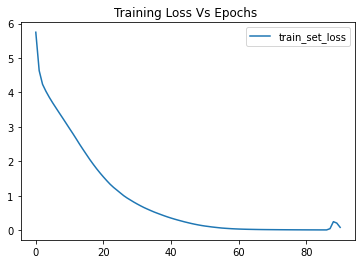

In [ ]:
import matplotlib.pyplot as plt
plt.title('Training Loss Vs Epochs ' )
# plt.plot(history1.history['acc'],label='train_set_acc')
plt.plot(history1.history['loss'],label='train_set_loss')
plt.legend()
plt.show() 

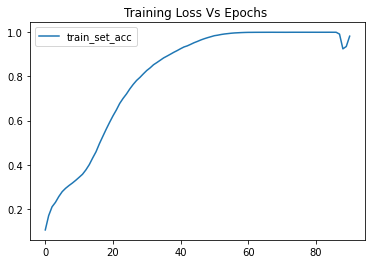

In [ ]:
import matplotlib.pyplot as plt
plt.title('Training Loss Vs Epochs ' )
plt.plot(history1.history['acc'],label='train_set_acc')
# plt.plot(history1.history['loss'],label='train_set_loss')
plt.legend()
plt.show() 

In [ ]:
# tf.keras.models.save_model(model , "/content/drive/MyDrive/DATA/pawan/ADL_P1/LSTM_rec")

In [9]:
model = tf.keras.models.load_model("/content/drive/MyDrive/DATA/pawan/ADL_P1/LSTM_rec")

In [10]:
import nltk

latent_dim=512
encoder_inputs = model.input[0]
sent_emb1 = model.layers[1].output

encoder_model = Model(encoder_inputs, sent_emb1)


In [ ]:
sent_emb = []
def decode_sequence(input_seq):
    temp = encoder_model.predict(input_seq)
    sent_emb.append(temp[0])

for seq_index in range(len(encoder_input_data)):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    if(seq_index%1000 == 0):
      print(seq_index)
    decode_sequence(input_seq)
       

In [ ]:
# np.save("/content/drive/MyDrive/DATA/pawan/ADL_P1/temp_LSTM_sent_embedding", sent_emb)

In [11]:
sent_emb = np.load("/content/drive/MyDrive/DATA/pawan/ADL_P1/temp_LSTM_sent_embedding.npy",  allow_pickle=True)

In [12]:
sentence_embeddings = []
i = 0
while(i < 4010):
  sentence_embeddings.append(np.asarray(sent_emb[i]).reshape(-1))
  i = i + 1


In [ ]:
np.asarray(sentence_embeddings).shape

(4010, 102400)

In [13]:
def get_query_emb(input_seq):
    temp = encoder_model.predict(input_seq)
    return temp[0]

In [73]:
from operator import itemgetter
import scipy 
def get_recommendation(seq_index):
  queries = encoder_input_data[seq_index: seq_index + 1]
  query_embeddings = get_query_emb(queries)
  query_embeddings = query_embeddings.reshape(-1)
  new_emb = []
  new_emb.append(query_embeddings)
  number_top_matches = 10
  for query, query_embedding in zip(queries, new_emb):
      distances = scipy.spatial.distance.cdist(new_emb, sentence_embeddings, "cosine")[0]
      results = zip(range(len(distances)), distances)
      results = sorted(results, key=lambda x: x[1])

      print("\n\n======================\n\n")
      list = target_lines[seq_index]
      str1 = ' '.join(list)
      print( "Query : ",str1 )
      # print("\nTop 10 most similar sentences in corpus:")
      temp = []
      # temp2 = {}
      for idx, distance in results[0:number_top_matches]:
        list = target_lines[idx]
        str1 = ' '.join(list)
        # temp2[1-distance] = str1
        temp.append(str1)
      # temp = sorted(temp2.items(), key = itemgetter(0), reverse=True)
      return temp

In [74]:
seq_index = 1136
get_recommendation(seq_index)






Query :  A Neural Approach to Blind Motion Deblurring


['A Neural Approach to Blind Motion Deblurring',
 'Abnormal Event Detection in Videos using Spatiotemporal Autoencoder',
 'AdaScan: Adaptive Scan Pooling in Deep Convolutional Neural Networks for\n  Human Action Recognition in Videos',
 'Seed, Expand and Constrain: Three Principles for Weakly-Supervised Image\n  Segmentation',
 'Hashmod: A Hashing Method for Scalable 3D Object Detection',
 'Enhanced Object Detection via Fusion With Prior Beliefs from Image\n  Classification',
 'Video Interpolation using Optical Flow and Laplacian Smoothness',
 'The More You Know: Using Knowledge Graphs for Image Classification',
 'A reliable order-statistics-based approximate nearest neighbor search\n  algorithm',
 'Human Pose Estimation in Space and Time using 3D CNN']

In [66]:
seq_index = 3652
get_recommendation(seq_index)





Query :  Deep Convolutional Poses for Human Interaction Recognition in Monocular
  Videos


['Deep Convolutional Poses for Human Interaction Recognition in Monocular\n  Videos',
 'Graph Construction with Label Information for Semi-Supervised Learning',
 'Approaching the Computational Color Constancy as a Classification\n  Problem through Deep Learning',
 'Deep convolutional neural networks for pedestrian detection',
 'The Role of Typicality in Object Classification: Improving The\n  Generalization Capacity of Convolutional Neural Networks',
 'Towards Better Analysis of Deep Convolutional Neural Networks',
 'A Data-driven Approach for Human Pose Tracking Based on Spatio-temporal\n  Pictorial Structure',
 'Fast and Provably Accurate Bilateral Filtering',
 'Texture Synthesis with Spatial Generative Adversarial Networks',
 'Detecting events and key actors in multi-person videos']

In [67]:
seq_index = 2088
get_recommendation(seq_index)





Query :  Persistent Homology on Grassmann Manifolds for Analysis of Hyperspectral
  Movies


['Persistent Homology on Grassmann Manifolds for Analysis of Hyperspectral\n  Movies',
 'Supervised multiview learning based on simultaneous learning of\n  multiview intact and single view classifier',
 'Where to Focus: Query Adaptive Matching for Instance Retrieval Using\n  Convolutional Feature Maps',
 'Efficient Discriminative Nonorthogonal Binary Subspace with its\n  Application to Visual Tracking',
 'Novel Views of Objects from a Single Image',
 'Dual Principal Component Pursuit',
 'Pandora: Description of a Painting Database for Art Movement Recognition\n  with Baselines and Perspectives',
 'Laplacian regularized low rank subspace clustering',
 'Comprehensive Feature-based Robust Video Fingerprinting Using Tensor\n  Model',
 'A Dataset for Improved RGBD-based Object Detection and Pose Estimation\n  for Warehouse Pick-and-Place']

In [72]:
seq_index = 3848
get_recommendation(seq_index)





Query :  Learning Quadrupedal Locomotion over Challenging Terrain


['Learning Quadrupedal Locomotion over Challenging Terrain',
 'A Concave Optimization Algorithm for Matching Partially Overlapping\n  Point Sets',
 'Statistics of RGBD Images',
 'Automatic Segmentation of Dynamic Objects from an Image Pair',
 'Deep convolutional neural networks for pedestrian detection',
 'Image denoising via group sparsity residual constraint',
 'Predicting the Category and Attributes of Visual Search Targets Using\n  Deep Gaze Pooling',
 'Greedy Structure Learning of Hierarchical Compositional Models',
 'A Data-driven Approach for Human Pose Tracking Based on Spatio-temporal\n  Pictorial Structure',
 'Predicting Face Recognition Performance Using Image Quality']

In [68]:
seq_index = 1038
get_recommendation(seq_index)





Query :  US-Cut: Interactive Algorithm for rapid Detection and Segmentation of
  Liver Tumors in Ultrasound Acquisitions


['US-Cut: Interactive Algorithm for rapid Detection and Segmentation of\n  Liver Tumors in Ultrasound Acquisitions',
 'Novel Views of Objects from a Single Image',
 'Adaptive Algorithm and Platform Selection for Visual Detection and\n  Tracking',
 'Hierarchical Deep Learning Architecture For 10K Objects Classification',
 'Human Action Recognition using Factorized Spatio-Temporal Convolutional\n  Networks',
 'Saliency Driven Object recognition in egocentric videos with deep CNN',
 'Where to Focus: Query Adaptive Matching for Instance Retrieval Using\n  Convolutional Feature Maps',
 'Using Filter Banks in Convolutional Neural Networks for Texture\n  Classification',
 'UnrealStereo: Controlling Hazardous Factors to Analyze Stereo Vision',
 'Sketch-based Image Retrieval from Millions of Images under Rotation,\n  Translation and Scale Variations']

In [69]:
import nltk
BleuScore = 0
sent_length = 200
num_sample =  len(encoder_input_data)
sentence_emb = []
def decode_sequence(input_seq):
    
    abstract_emb = encoder_model.predict(input_seq)
    temp = []
    target_seq = np.zeros((1, 1))
    
    target_seq[0, 0] = 1
    
    stop_condition = False
    decoded_sentence = []

    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        temp.append(c)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print("sampled_token_index",sampled_token_index)
        sampled_char = index2token[sampled_token_index]
        #print("sampled_char",sampled_char)
        

        # # Exit condition: either hit max length
        # # or find stop character.
        
        if sampled_char == 'EOS' or len(decoded_sentence) > sent_length:
          stop_condition = True
        else:
          decoded_sentence.append(sampled_char)
        


        # # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]
    sentence_emb.append(temp)
    return decoded_sentence

for seq_index in range(2):
    input_seq = encoder_input_data[2008+seq_index: 2008+seq_index + 1]
    if(seq_index%1000 == 0):
      print(seq_index)
    # print('Input sentence length : ', encoder_input_data[seq_index].size)
    decoded_sentence = decode_sequence(input_seq)
  
    # print('-',seq_index)
    # print('Input sentence:      ', input_valid_lines[seq_index].split(' '))
    print('Decoded sentence:    ', decoded_sentence)


0


NameError: ignored